# Environment Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/ECE1512/ProjectA/mhist_dataset/images.zip", 'r')
zip_ref.extractall("./")
zip_ref.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Input, Lambda, Conv2D, MaxPooling2D
from tensorflow import keras
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf
import numpy as np


# Load The Dataset

In [ ]:
from torch._C import Size
import torch
import os
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


BATCH_SIZE = 32
np.random.seed(32)

def load_data(image_path, csv_path, split):
    annotations = pd.read_csv(csv_path)
    data = annotations[annotations['Partition'] == split].reset_index(drop=True)
    return data, image_path

def get_item(data, image_path, idx, transformer):
    image_full_name = os.path.join(image_path, data.iloc[idx]['Image Name'])
    x = Image.open(image_full_name)

    if transformer:
        x = transformer(x)
        x = x.permute(1, 2, 0)

    label = data.iloc[idx]['Majority Vote Label']
    y = torch.tensor([1, 0]) if label == 'HP' else torch.tensor([0, 1])

    return x, y

def data_loader(data, image_path, transformer, batch_size, shuffle=True):
    items = []
    for idx in range(len(data)):
        x, y = get_item(data, image_path, idx, transformer)
        items.append((x, y))
    return DataLoader(items, batch_size=batch_size, shuffle=shuffle)

custom_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_path = "/content/images"
csv_path = "/content/drive/MyDrive/ECE1512/ProjectA/mhist_dataset/annotations.csv"

train_data, train_image_path = load_data(image_path, csv_path, 'train')
test_data, test_image_path = load_data(image_path, csv_path, 'test')


train_loader = data_loader(train_data, train_image_path, custom_transformer, BATCH_SIZE)
test_loader = data_loader(test_data, test_image_path, custom_transformer, BATCH_SIZE, shuffle=False)



# Load Model
Load the pre-trained ResNet50V2 and MobileNetV2 Model

In [ ]:
#Teacher Model = ResNet50V2

IMAGE_SIZE = (224, 224, 3)
resnet_model = ResNet50V2(include_top=True, weights='imagenet', input_shape=IMAGE_SIZE)

#Freeze the Pre-traine ResNet50V2 for inital epochs
for layer in resnet_model.layers:
    layer.trainable = False

last_teacher = Dense(2, activation=None)(resnet_model.output)  # raw logits for binary classification
last_teacher.trainable = True

#Create the New Teacher Model
teacher_model = Model(inputs=resnet_model.input, outputs=last_teacher)

102869336/102869336 [==============================] - 0s 0us/step


In [ ]:
#Student Model = MobileNetV2
mobilenet_model = MobileNetV2(include_top=True, weights='imagenet', input_shape=IMAGE_SIZE)

for layer in mobilenet_model.layers:
    layer.trainable = False

last_student = Dense(2, activation=None)(mobilenet_model.output)
last_student.trainable = True

student_model = Model(inputs=mobilenet_model.input, outputs=last_student)

In [ ]:
#Student Model from Scratch
mobile_model_scratch = MobileNetV2(include_top=True, weights='imagenet', input_shape=IMAGE_SIZE)
#freeze pre-trained mobilenet layers for initial epochs
for layer in mobile_model_scratch.layers:
    layer.trainable = False

#Design the last dense layer
x_student_scratch = Dense(2, activation=None)(mobile_model_scratch.output)
x_student_scratch.trainable = True

student_model_scratch = Model(inputs=mobile_model_scratch.input, outputs=x_student_scratch)


# Loss Function

In [ ]:
import tensorflow as tf

@tf.function
def compute_teacher_loss(images, labels):
    """Compute the teacher loss for given images and labels.

    Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

    Returns:
    Scalar loss Tensor.
    """
    logits = teacher_model(images, training=True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, logits))
    return loss

In [ ]:
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4 #temperature hyperparameter

def distillation_loss(teacher_logits, student_logits, temperature = DISTILLATION_TEMPERATURE):

    soft_targets = tf.nn.softmax(teacher_logits/temperature, axis = 1)

    return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):

    student_subclass_logits = student_model(images, training=True)
    teacher_subclass_logits = teacher_model(images, training=False)
    distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

    cross_entropy_loss_value = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          labels, student_subclass_logits))

    total_loss = cross_entropy_loss_value * ALPHA + (1 - ALPHA) * distillation_loss_value

    return total_loss

#Train and Evaluation

In [ ]:
NUM_EPOCHS_INIT = 10
NUM_EPOCHS_FT = 25
NUM_CLASSES = 2
LEARNING_RATE_REDUCTION_FACTOR = 10

def compute_AUC(model, images, labels):
    """
    Computes AUC for given model predictions and adjusts the logits if needed.
    """
    class_logits = model(images, training=False)

    # Adjust logits if they don't match the expected shape by splitting and summing
    if class_logits.shape[1] != NUM_CLASSES:
        split_data = tf.split(class_logits, [8, 8], axis=-1)
        class_logits = tf.stack([tf.reduce_sum(i, axis=-1) for i in split_data], axis=-1)

    scores = tf.nn.sigmoid(class_logits)

    auc_metric = tf.keras.metrics.AUC()
    auc_metric.reset_state()
    auc_metric.update_state(labels, scores)
    return auc_metric.result().numpy()

def train_and_evaluate(model, compute_loss_fn, learning_rate, train_loader, test_loader):
    print('--- Start Initial Training Epochs ---')
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    # Initial Training Phase
    for epoch in range(1, NUM_EPOCHS_INIT + 1):
        print('Epoch {}: '.format(epoch), end='')
        for images, labels in train_loader:
            with tf.GradientTape() as tape:
                images = tf.convert_to_tensor(images.numpy())
                labels = tf.convert_to_tensor(labels.numpy())
                loss_value = compute_loss_fn(images, labels)

            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Unfreeze all layers and fine-tune
    for layer in model.layers:
        layer.trainable = True
    print('\n--- Start Fine-Tuning Epochs ---')
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate/LEARNING_RATE_REDUCTION_FACTOR)

    for epoch in range(1, NUM_EPOCHS_FT + 1):
        print(f'Epoch {epoch}: ', end='')
        for images, labels in train_loader:
            with tf.GradientTape() as tape:
                images = tf.convert_to_tensor(images.numpy())
                labels = tf.convert_to_tensor(labels.numpy())
                loss_value = compute_loss_fn(images, labels)

            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))


    # Evaluation
    AUC_set = [compute_AUC(model, tf.convert_to_tensor(images.numpy()), tf.convert_to_tensor(labels.numpy()))
               for images, labels in test_loader]
    test_AUC = sum(AUC_set) / len(AUC_set) * 100
    print(f'\nTest AUC: {test_AUC:.2f}')
    return test_AUC


# Training Model

In [ ]:
print('Training teacher model:')
test_acc_teacher = train_and_evaluate(teacher_model, compute_teacher_loss, 1e-4, train_loader, test_loader)


Training teacher model:
--- Start Initial Training Epochs ---
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: 
--- Start Fine-Tuning Epochs ---
Epoch 1: 

Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Epoch 13: Epoch 14: Epoch 15: Epoch 16: Epoch 17: Epoch 18: Epoch 19: Epoch 20: Epoch 21: Epoch 22: Epoch 23: Epoch 24: Epoch 25: 
Test AUC: 85.13


In [ ]:
print('Training Student model:')
test_acc_student = train_and_evaluate(student_model, compute_student_loss, 1e-3, train_loader, test_loader)

Training Student model:
--- Start Initial Training Epochs ---
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: 
--- Start Fine-Tuning Epochs ---
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Epoch 13: Epoch 14: Epoch 15: Epoch 16: Epoch 17: Epoch 18: Epoch 19: Epoch 20: Epoch 21: Epoch 22: Epoch 23: Epoch 24: Epoch 25: 
Test AUC: 80.09


# Test Accuracy vs. Tempreture Curve

In [ ]:
print("Tune Hyperparameter for the student model")
temperature_set = [1,2,4,16,32,64]
alpha_set = [0.2,0.5,]
test_auc_set = []
best_acc = 0
best_alpha = 0
best_temperature = 0

for a in alpha_set:
  for temp in temperature_set:
    print(f"=============a:{a}===t:{temp}===============")
    mobile_model_tune = MobileNetV2(include_top=True, weights='imagenet', input_shape=IMAGE_SIZE)
    #freeze pre-trained mobilenet layers for initial epochs
    for layer in mobile_model_tune.layers:
        layer.trainable = False

    #Design the last dense layer
    x_student = Dense(2,activation=None)(mobile_model_tune.output)
    x_student.trainable = True

    student_model_kd = Model(inputs=mobile_model_tune.input, outputs=x_student)

    DISTILLATION_TEMPERATURE = temp
    ALPHA = a
    test_auc_i = train_and_evaluate(student_model, compute_student_loss, 1e-3, train_loader, test_loader)
    if a==0.5:
      test_auc_set.append(test_auc_i)
    if test_auc_i > best_acc:
      best_acc = test_auc_i
      best_alpha = a
      best_temperature = temp

# Output the best accuracy and its corresponding alpha and temperature
best_acc, best_alpha, best_temperature

Tune Hyperparameter for the student model
=============a:0.2===t:1===============
--- Start Initial Training Epochs ---
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: 
--- Start Fine-Tuning Epochs ---
Epoch 1: 

Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Epoch 13: Epoch 14: Epoch 15: Epoch 16: Epoch 17: Epoch 18: Epoch 19: Epoch 20: Epoch 21: Epoch 22: Epoch 23: Epoch 24: Epoch 25: 
Test AUC: 74.68
=============a:0.2===t:2===============
--- Start Initial Training Epochs ---
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: 
--- Start Fine-Tuning Epochs ---
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Epoch 13: Epoch 14: Epoch 15: Epoch 16: Epoch 17: Epoch 18: Epoch 19: Epoch 20: Epoch 21: Epoch 22: Epoch 23: Epoch 24: Epoch 25: 
Test AUC: 84.87
=============a:0.2===t:4===============
--- Start Initial Training Epochs ---
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: 
--- Start Fine-Tuning Epochs ---
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 

(88.82755367986618, 0.5, 0)

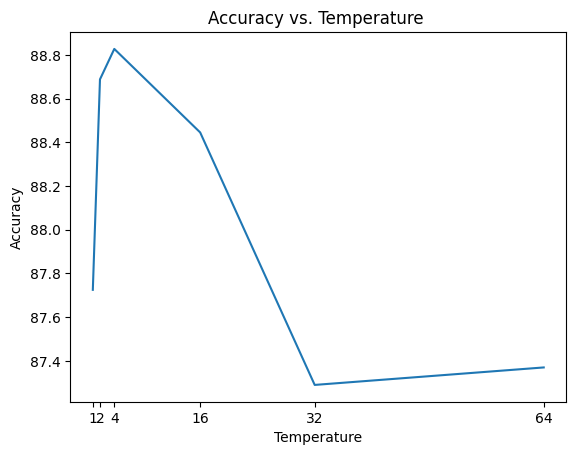

In [ ]:

import matplotlib.pyplot as plt
plt.plot(temperature_set, test_auc_set)

plt.xticks(temperature_set)
plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Temperature ')
plt.show()

# Training Student from Scratch First

In [ ]:
def compute_plain_cross_entropy_loss(images, labels):
    student_subclass_logits = student_model_scratch(images, training=True)
    cross_entropy_loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          labels, student_subclass_logits))

    return cross_entropy_loss

train_and_evaluate(student_model_scratch, compute_plain_cross_entropy_loss, 1e-3, train_loader, test_loader)

--- Start Initial Training Epochs ---
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: 
--- Start Fine-Tuning Epochs ---
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Epoch 13: Epoch 14: Epoch 15: Epoch 16: Epoch 17: Epoch 18: Epoch 19: Epoch 20: Epoch 21: Epoch 22: Epoch 23: Epoch 24: Epoch 25: 
Test AUC: 73.08


73.07740687843291

# Comparing the teacher and student model (number of of parameters and FLOPs)
citation: Tokusumi (2020). flops_calculation.py.  keras_flops.https://github.com/tokusumi/keras-flops/blob/master/keras_flops/flops_calculation.py

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph
def get_flops(model, batch_size=None):
    if batch_size is None:
        batch_size = 1

    # Wrap the model's call function in a tf.function
    @tf.function
    def model_forward(input_data):
        return model(input_data)

    # Get a concrete function
    real_model = model_forward.get_concrete_function(tf.TensorSpec([batch_size] + model.inputs[0].shape[1:], model.inputs[0].dtype))

    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(real_model)

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,
            run_meta=run_meta, cmd='op', options=opts)
    return flops.total_float_ops

print("====================Teacher Model==================")
model = teacher_model
model.summary()

print("==================Student Model====================")
model = student_model
model.summary()

print("==========Student Model from Scratch=============")
model = student_model_scratch
model.summary()


====================Teacher Model==================
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                          

In [ ]:
print("=============FLop======================")
flops = get_flops(teacher_model, 32)
print(f"Teacher FLOPS: {flops}")
flops = get_flops(student_model, 32)
print(f"Student FLOPS: {flops}")
flops = get_flops(model, 32)
print(f"Student Scratch FLOPS: {flops}")

=============FLop======================


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Teacher FLOPS: 223296578112
Student FLOPS: 19258804800
Student Scratch FLOPS: 19258804800


# XAI method to explain models
ciation: Mohammadi, Seyedmahmoud. "xai_utils.py." ECE1512_2022W_ProjectRepo, GitHub, 2023, https://github.com/RezaMohammadi99/ECE1512_2022W_ProjectRepo_Seyedmahmoud-Mohammadi/blob/main/Project_A/xai_utils.py.

In [ ]:
"""
ciation: Mohammadi, Seyedmahmoud.
"xai_utils.py." ECE1512_2022W_ProjectRepo, GitHub, 2023,
https://github.com/RezaMohammadi99/ECE1512_2022W_ProjectRepo_Seyedmahmoud-Mohammadi/blob/main/Project_A/xai_utils.py.
"""
import cv2
from time import time
import os
import numpy as np
import json

import tensorflow as tf
from tensorflow import keras
from scipy.ndimage.interpolation import zoom
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow.keras.backend as K
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
#############################


def layer_finder(k_model, model_arch, pool_input=True):

  '''
  Returns a list of all of the last layers in each block of the model.

    Parameters:
      k_model (Keras model): Either a VGG or ResNet
      model_arch (str): Either "VGG" or "ResNet"

    Returns:
      last_layers (list): A list of all of the last layers in each block of the
      model.
  '''

  if type(model_arch) != str:
    raise TypeError("Input argument \"model_arch\" must be a string that is\
                      either \"VGG\" or \"ResNet\".")

  last_layers = []
  pool_flag=False
  block_end_detected=False
  first_layer=True
  j=0

  if model_arch == "VGG":

    for layer in k_model.layers:
      if type(layer) == tf.keras.layers.MaxPool2D:
        last_layers.append(layer.name)

  elif model_arch == "ResNet":


    for i in range(len(k_model.layers)):
      if i<j: continue
      #print(k_model.layers[i])
      if len(k_model.layers[i+1].output.get_shape()) < 4:
        # only save a layer if the block before the end was a convolutional block
            last_layers.append(k_model.layers[i].name)
            break

      if k_model.layers[i+1].output.get_shape()[2]<k_model.layers[i].output.get_shape()[2]-4:
          if pool_input==True:
              if type(k_model.layers[i]) == tf.keras.layers.InputLayer: continue
              if 'ZeroPadding2D' in str(type(k_model.layers[i])):
                  if type(k_model.layers[i-1]) == tf.keras.layers.InputLayer: continue
                  last_layers.append(k_model.layers[i-1].name)
              else:
                  last_layers.append(k_model.layers[i].name)
          else:
              if first_layer:
                  j=i+1
                  pool_flag=True
                  while(pool_flag):
                      j += 1
                      #print(str(type(k_model.layers[j])))
                      if  'Conv2D' in str(type(k_model.layers[j])):
                          #print('Here')
                          last_layers.append(k_model.layers[j-1].name)
                          first_layer=False
                          pool_flag=False
              else:
                  j=i
                  pool_flag=True
                  while(pool_flag):
                      j += 1
                      #print(str(type(k_model.layers[j])))
                      if 'merge.Add' in str(type(k_model.layers[j])):
                          block_end_detected=True
                          #print(j)
                      elif block_end_detected==True and 'Conv2D' in str(type(k_model.layers[j])):
                          #print('Here')
                          last_layers.append(k_model.layers[j-1].name)
                          block_end_detected=False
                          pool_flag=False
  else:

    print("Input argument \"model_arch\" must be either \"VGG\" or \"ResNet\".")

  return [[lay] for lay in last_layers]
def create_random_mask(h=7, w=7, H=224, W=224, p_1=0.5, resample=Image.BILINEAR):
    '''
    Generates one random mask utilized in RISE
    inputs:
        h, w: initial size of binary mask
        H, W: final size of the upsampled mask
        p_1: probability of actiating pixels in the down-sampled masks.
        interp: upsampling technique.
    returns:
        mask: a smooth mask with the values in range [0,1] with size of HxW.
    '''
    assert H>h, 'Masks should be resized to higher dimensions.'
    assert W>w, 'Masks should be resized to higher dimensions.'
    # create random binary hxw mask
    mask=np.random.choice([0, 1], size=(h, w), p=[1-p_1, p_1])

    # upsample mask to (h+H,w+W)
    mask = Image.fromarray(mask*255.)
    mask = mask.resize((H + h, W + w), resample=resample)
    mask = np.array(mask)

    # randomly crop mask to HxW
    w_crop = np.random.randint(0,w+1)
    h_crop = np.random.randint(0,h+1)
    mask = mask[h_crop:H + h_crop, w_crop:W + w_crop]

    # normalize between 0 and 1
    mask /= np.max(mask)

    return mask

def create_attribution_masks(img, model, layers, class_index, max_mask_num, interp='bilinear'):
    '''
    Derives feature maps from one, or a couple of layers, and post-processes them
    to convert them to attribution masks.

    inputs:
        img: a 4-D tensor image.
        model: the classification model
        layers: list of layers to be visualized either individually or mutually.
        class_index: the output class according to whom the layer(s) are visualized.
        max_mask_num: the threshold "normalized gradient" value for sampling attribution masks (\mu in our paper)
        interp: upsampling technique.
        For now, 'bilinear' and 'nearest' are supported.
    returns:
        masks: a set of attribution masks normalized between 0 and 1.
    '''
    assert interp in ['bilinear', 'nearest'], 'Selected upsampling type undefined or unsupported.'
    # Forward pass to get attribution masks.
    conv_outputs=[]
    for layer in model.layers:
        if np.isin(layer.name,layers):
            conv_outputs.append(layer.output)
    conv_outputs.append(model.output)
    feedforward1=keras.models.Model([model.input], [conv_outputs])
    with tf.GradientTape() as tape:
        ff_results=feedforward1([img])[0]
        all_fmap_masks, predictions = ff_results[:-1], ff_results[-1]
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, all_fmap_masks)
    ###

    # upsample and normalize masks.
    num_masks=0
    masks=[]
    for i in range(len(layers)):
        tmp_mask = all_fmap_masks[i][0].numpy()
        if len(img.shape)==3:
            axis=0
            size=img.shape[1:]
            tmp_mask = np.expand_dims(tmp_mask, axis=1)
        elif len(img.shape)==4:
            axis=(0,1)
            size=img.shape[1:-1]
        significance = np.mean(grads[i][0], axis=axis)
        #idxs = np.argpartition(significance, -1*max_mask_num)[-1*max_mask_num:]
        idxs = np.where(significance>max_mask_num*np.max(significance))[0]
        if interp == 'bilinear':
            fmap = tf.image.resize(tmp_mask[...,idxs], size, method='bilinear').numpy()
        elif interp == 'nearest':
            fmap = tf.image.resize(tmp_mask[...,idxs], size, method='nearest').numpy()
        else: raise ValueError('You have selected an unsupported interpolation type.')

        num_masks+=fmap.shape[2]
        fmap -= np.min(fmap, axis=(0,1))
        fmap /= (np.max(fmap, axis=(0,1))+10e-7)
        masks.append(fmap)
    return masks

def visualize_layers(img, model, class_index, masks, H=224, W=224, C=3, batch_size = 128):
    '''
    Combines attribution masks using the RISE-based framework mentioned in
    SISE white paper.
    inputs:
        img: a 3-D tensor image.
        model: the classification model
        class_index: the output class according to whom the layer(s) are visualized.
        masks: a set of attribution masks normalized between 0 and 1.
    returns:
        sum_masks: visualization map of the selected layer(s).
    This function follows 'create_attribution_masks()'.
    '''
    # creates perturbed images to probe model.
    img = img if len(img.shape)==3 else np.expand_dims(img, axis=1)
    X = np.einsum('hwc,hwn->nhwc', img, masks)
    # second forward pass to valuate attribution maps
    preds_masked = np.empty([0])
    if masks.shape[2] <= batch_size :
      preds_masked=np.append(preds_masked, model(X, training=False)[:,class_index],axis=0)
    else :
      for i in range (0, masks.shape[2]-batch_size, batch_size) :
        preds_masked=np.append(preds_masked, model(X[i:i+batch_size], training=False)[:,class_index],axis=0)
      preds_masked=np.append(preds_masked, model(X[i+batch_size:], training=False)[:,class_index],axis=0)

    # Linear combination of attribution masks.
    masks /= (masks.sum(axis=(0,1))+10e-7)
    sum_mask = np.einsum('hwn,n->hw', masks, preds_masked)

    sum_mask -= np.min(sum_mask)
    sum_mask /= np.max(sum_mask)
    return sum_mask

def otsu(I, nbins=256, tau=1.5):
    '''
    Finds the optimum adaptive threshold value for a 2-D image.
    inputs:
        I: a 2-D image (visualization map/ heat-map/ etc.)
        nbins: resolution of histogram. Increasing this parameter yields to more
        precise threshold value, achieved in longer time.
        tau: bottleneck amplititude
        returns: Otsu adaptive threshold value
    '''
    I = np.round(I*nbins)
    #histogram of the image
    hist, bins = np.histogram(I.ravel(),nbins,[0,nbins])
    #CDF/ mean/ variance terms for multiple values
    i = np.arange(nbins)
    varsb = np.zeros(nbins)
    for j in range(1, nbins):
        w0 = np.sum(hist[0:j])
        w1 = np.sum(hist[j:nbins])
        u0 = np.sum(np.multiply(hist[0:j], i[0:j])) / w0
        u1 = np.sum(np.multiply(hist[j:nbins], i[j:nbins])) / w1
        varsb[j] = w0 * w1 * (u0-u1) * (u0-u1)
    # the threshold value is the one maximizing the variance term.
    t = np.argmax(varsb)
    #print(t)
    k = round(t*tau)
    if np.sum(hist[int(k):256]) < .1 * np.sum(hist):
        #print('happened')
        return t*tau/nbins
    else:
        return t/nbins

def otsu_sigmoid(I, nbins=256, T=100., tau=1.5):
    '''
        Thresholds the 2-D visualization map softly, combining Otsu's method and
        sigmoid function.
        inputs:
            I: a 2-D image (visualization map/ heat-map/ etc.)
            nbins: resolution of histogram. Increasing this parameter yields to more
            precise threshold value, achieved in longer time.
            T: sigmoid temparature (preferred to be set to high values.)
        returns:
            the soft-thresholded heat-map according to the input.
    '''
    thr=otsu(I, nbins=256, tau=1.5)
    return 1/(1 + np.exp(-(I-thr)*T))

def fuse_visualization_maps(exmaps, fusion_type='otsu', T=100.):
    '''
    Fuses visualization maps to a unique explanation map. Visualization maps should
    be given with the correct order (low-level layer to high-level layer)

    '''
    assert fusion_type in ['simple', 'otsu']
    ex=exmaps[0]
    if fusion_type=='simple':
        for i in range(1, len(exmaps)):
            ex += exmaps[i]
            ex *= exmaps[i]
    elif fusion_type=='otsu':
        for i in range(1, len(exmaps)):
            ex += exmaps[i]
            ex *= otsu_sigmoid(exmaps[i], T=T)
    return ex

def SISE(img, model, class_index, layers, grad_thr, interp='bilinear',
         fusion_type='otsu', T=100.):

    '''
    For now, this function supports VGG16, ResNet50, and ResNet101.
    img: a 4-D image, or a 3-D array.
    model: the classification model
    layers: list of layers to be visualized either individually or mutually.
    interp: upsampling technique.
    Check the supproted upsampling types in function 'create_attribution_masks'.
	grad_thr: Threshold on the average gradient values to select the most appropriate feature maps.
    fusion_type: the fusion technipue for visualization maps:
        simple: Using only addition and multiplication blocks.
        otsu: Using addition, soft otsu threshold, and multiplication blocks.
    auto_layer_finder: if 'True', the layers are automatically selected. Otherwise,
        pre-defined layers for the models experimented are used.
    pool_input_select: If True, the inputs of pooling layers are detected automatically.
        Otherwise,  the outputs of pooling layers are detected automatically.
        If 'auto_layer_finder=False', this parameter is ineffective.
    '''
    masks = create_attribution_masks(img, model, layers, class_index=class_index, max_mask_num = grad_thr, interp=interp)
    exmaps=[]
    for mask_set in masks:
        exmaps.append(visualize_layers(img[0], model, class_index, mask_set))
    return fuse_visualization_maps(exmaps, fusion_type=fusion_type, T=T)


def weighted_fusion(w,exmaps, T=100.):
    '''
    Objective: weighted fusion using weighted addition, unweighted multiplication, and otsu threshold blocks.
    inputs:
        w: an array of weight factors of length N-1.
        exmaps: a 3-D array of explanation maps of length H x W x N.
    parameters:
        N: number of visualiation maps received
        H x W: size of visualization maps.
    outputs:
        e_out: fused explanation map.
    '''
    #w_post=np.maximum(w,0)
    w_post=np.clip(a=w, a_min=0, a_max=2)
    e23=np.multiply((exmaps[:,:,0]*w_post[0]+exmaps[:,:,1]*(2-w_post[0])),
                    otsu_sigmoid(exmaps[:,:,1], T=T))
    e234=np.multiply((e23*w_post[1]+exmaps[:,:,2]*(2-w_post[1])),
                    otsu_sigmoid(exmaps[:,:,2], T=T))
    e2345=np.multiply((e234*w_post[2]+exmaps[:,:,3]*(2-w_post[2])),
                    otsu_sigmoid(exmaps[:,:,3], T=T))
    e23456=np.multiply((e2345*w_post[3]+exmaps[:,:,4]*(2-w_post[3])),
                    otsu_sigmoid(exmaps[:,:,4], T=T))
    e_out = e23456
    return e_out

def grad_cam(input_model, image, layer_name):
    cls = np.argmax(input_model.predict(image))
    def normalize(x):
        """Utility function to normalize a tensor by its L2 norm"""
        return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output
    conv_output = input_model.get_layer(layer_name).output
    feedforward1 = keras.models.Model([input_model.input], [conv_output, y_c])
    with tf.GradientTape() as tape:
        ff_results=feedforward1([image])
        all_fmap_masks, predictions = ff_results[0], ff_results[-1]
        loss = predictions[:, cls]
    grads_val = tape.gradient(loss, all_fmap_masks)
    if len(image.shape)==3:
        axis=(0, 1)
    elif len(image.shape)==4:
        axis=(0, 1, 2)
    weights = np.mean(grads_val, axis=axis)
    cam = np.dot(all_fmap_masks[0], weights)
    H,W= image.shape[1:3]
    cam = np.maximum(cam, 0)
    cam = zoom(cam,H/cam.shape[0])
    cam = cam / cam.max()
    return cam

def RISE(img, model, class_index, N_MASKS=8000, H=224, W=224, C=3):
    '''
	img: a 3-D input image
	model: a trained model
	class_index; The class of interest
	N_MASKS: The number of random masks to be generated
	H,W,C: The desired dimensions of the random masks
	'''
    X = np.zeros(shape=(N_MASKS, H, W, C), dtype=np.float32)
    masks = np.zeros((N_MASKS,H,W), dtype=np.float32)
    #for i in tqdm(range(N_MASKS)):
    for i in range(N_MASKS):
        m =create_random_mask(H=H, W=W)
        masks[i] = m
        x = img.copy()

        x[:, :, 0] *= m
        #x[:, :, 1] *= m
        #x[:, :, 2] *= m
        X[i] = x
    preds_masked = model.predict(X, verbose=0)
    sum_mask = np.zeros(masks[0].shape, dtype=np.float32)

    # np.einsum???
    for i, mask in enumerate(masks):
        m = mask * preds_masked[i, class_index]
        sum_mask += m

    sum_mask -= np.min(sum_mask)
    sum_mask /= np.max(sum_mask)
    return sum_mask

In [ ]:
k = 0
index = 0
for next_batch in train_loader:
    #print(np.array(next_batch[0]).shape)   #image
    image_batch = next_batch[0]
    image_batch = tf.convert_to_tensor(image_batch)
    prediction_teacher = teacher_model.predict(image_batch)
    prediction_student = student_model.predict(image_batch)
    label = next_batch[1]
    #print(np.array(next_batch[1]).shape)   #label

    img = np.array(image_batch[index])

    explanation_map_RISE1 = RISE(img, teacher_model, class_index=np.argmax(prediction_teacher[index]) ,N_MASKS=1000,H=224, W=224, C=3)  #
    explanation_map_RISE1 -= explanation_map_RISE1.min()
    explanation_map_RISE1 /= explanation_map_RISE1.max()+10e-30

    explanation_map_RISE2 = RISE(img, student_model, class_index=np.argmax(prediction_student[index]) ,N_MASKS=1000,H=224, W=224, C=3)
    explanation_map_RISE2 -= explanation_map_RISE2.min()
    explanation_map_RISE2 /= explanation_map_RISE2.max()+10e-30

    explanation_map_RISE3 = RISE(img, student_model_scratch, class_index=np.argmax(prediction_student[index]) ,N_MASKS=1000,H=224, W=224, C=3)
    explanation_map_RISE3 -= explanation_map_RISE3.min()
    explanation_map_RISE3 /= explanation_map_RISE3.max()+10e-30

    plt.figure(figsize=(20,5))
    plt.subplot(1,4,1)
    plt.imshow(img[:,:,0])
    plt.axis('off')
    plt.title('Sample image')

    plt.subplot(1,4,2)
    plt.imshow(img[:,:,0])
    plt.imshow(explanation_map_RISE1, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title('Explanation map teacher)')

    plt.subplot(1,4,3)
    plt.imshow(img[:,:,0])
    plt.imshow(explanation_map_RISE2, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title('Explanation map student with KD')

    plt.subplot(1,4,4)
    plt.imshow(img[:,:,0])
    plt.imshow(explanation_map_RISE3, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title('Explanation map student without KD')
    plt.show()

    k += 1
    print(k)
    if k == 10:
      break


# Implementing the state-of-the-art KD algorithm (Part a)
Choose paper of citation 15: Subclass_Knowledge_Distillation_with_Known_Subclass_Labels.pdf
using the skd

In [ ]:
from torch._C import Size
import torch
import os
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


BATCH_SIZE = 32
np.random.seed(42)

def load_data_skd(image_path, csv_path, split):
    annotations = pd.read_csv(csv_path)
    data = annotations[annotations['Partition'] == split].reset_index(drop=True)
    return data, image_path

def get_item_skd(data, image_path, idx, transformer):
    image_full_name = os.path.join(image_path, data.iloc[idx]['Image Name'])
    x = Image.open(image_full_name)

    if transformer:
        x = transformer(x)
        x = x.permute(1, 2, 0)

    annotator_count = data.iloc[idx]['Number of Annotators who Selected SSA (Out of 7)']
    if annotator_count <= 1:

      y = torch.tensor([1, 0, 0, 0]) # Strongly Disagree
    elif annotator_count <= 3:
      y = torch.tensor([0, 1, 0, 0]) # Disagree
    elif annotator_count <= 5:
      y = torch.tensor([0, 0, 1, 0]) # Agree
    else:
      y = torch.tensor([0, 0, 0, 1]) # Strongly Agree

    return x, y




def data_loader_skd(data, image_path, transformer, batch_size, shuffle=True):
    items = []
    for idx in range(len(data)):
        x, y = get_item_skd(data, image_path, idx, transformer)
        items.append((x, y))
    return DataLoader(items, batch_size=batch_size, shuffle=shuffle)

custom_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_path = "/content/images"
csv_path = "/content/drive/MyDrive/ECE1512/ProjectA/mhist_dataset/annotations.csv"

train_data_skd, train_image_path = load_data_skd(image_path, csv_path, 'train')
test_data_skd, test_image_path = load_data_skd(image_path, csv_path, 'test')


train_loader_skd = data_loader_skd(train_data_skd, train_image_path, custom_transformer, BATCH_SIZE)
test_loader_skd = data_loader_skd(test_data_skd, test_image_path, custom_transformer, BATCH_SIZE, shuffle=False)



In [ ]:
IMAGE_SIZE = (224, 224, 3)
# Initialize ResNet50V2 with ImageNet weights
resnet_model = ResNet50V2(include_top=True, weights='imagenet', input_shape=IMAGE_SIZE)

# Freeze the pre-trained ResNet50V2 layers for initial epochs
for layer in resnet_model.layers:
    layer.trainable = False

# Design the last dense layer for the teacher model
last_teacher = Dense(4, activation=None)(resnet_model.output)  # raw logits for binary classification
last_teacher.trainable = True

# Create the new teacher model
teacher_model_skd = Model(inputs=resnet_model.input, outputs=last_teacher)

In [ ]:
from tensorflow.python.ops.nn_ops import softmax
# Initialize MobileNetV2 with ImageNet weights
mobilenet_model = MobileNetV2(include_top=True, weights='imagenet', input_shape=IMAGE_SIZE)

# Freeze the pre-trained MobileNetV2 layers for initial epochs
for layer in mobilenet_model.layers:
    layer.trainable = False

# Design the last dense layer
last_student = Dense(4, activation=None)(mobilenet_model.output)  # raw logits for binary classification
last_student.trainable = True

# Create the new model
student_model_skd = Model(inputs=mobilenet_model.input, outputs=last_student)


In [ ]:
import tensorflow as tf

@tf.function
def compute_teacher_loss_skd(images, labels):
    """Compute the teacher loss for given images and labels.

    Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

    Returns:
    Scalar loss Tensor.
    """
    logits = teacher_model_skd(images, training=True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, logits))
    return loss

In [ ]:
def compute_student_loss_skd(images, labels):
    """Compute subclass knowledge distillation student loss for given images
       and labels.

    Args:
      images: Tensor representing a batch of images.
      labels: Tensor representing a batch of labels.

    Returns:
      Scalar loss Tensor.
    """
    student_subclass_logits = student_model_skd(images, training=True)
    teacher_subclass_logits = teacher_model_skd(images, training=False)

    student_predictions = tf.nn.sigmoid(student_subclass_logits)
    teacher_predictions = tf.nn.sigmoid(teacher_subclass_logits)

    # Compute Hamming distance between teacher and student one-hot vectors
    hamming_distance = tf.math.abs(student_predictions - teacher_predictions)

    # Assign weights based on Hamming distance
    weights = tf.where(hamming_distance == 1, 1.0,  # 1x weight for distance of 1
                       tf.where(hamming_distance == 2, 1.5,  # 2x weight for distance of 2
                                0.0))  # 0 weight for distance of 0

    distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

    # Adjust distillation loss based on weights
    distillation_loss_value = distillation_loss_value * tf.reduce_mean(weights)

    # Compute cross-entropy loss with hard targets.
    cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits))

    # Combine the cross-entropy loss and distillation loss.
    total_loss = ALPHA *  cross_entropy_loss_value + (1.0 - ALPHA) * distillation_loss_value

    return total_loss


In [ ]:
NUM_EPOCHS_INIT = 10
NUM_EPOCHS_FT = 25
NUM_CLASSES = 4
LEARNING_RATE_REDUCTION_FACTOR = 10

def compute_auc_skd(model, images, labels):
    """
    Computes AUC for given model predictions and adjusts the logits if needed.
    """
    class_logits = model(images, training=False)

    # Adjust logits if they don't match the expected shape by splitting and summing
    if class_logits.shape[1] != NUM_CLASSES:
        split_data = tf.split(class_logits, [8, 8], axis=-1)
        class_logits = tf.stack([tf.reduce_sum(i, axis=-1) for i in split_data], axis=-1)

    scores = tf.nn.sigmoid(class_logits)

    auc_metric = tf.keras.metrics.AUC()
    auc_metric.reset_state()
    auc_metric.update_state(labels, scores)

    return auc_metric.result().numpy()

def train_and_evaluate_skd(model, compute_loss_fn, learning_rate, train_loader, test_loader):
    print('--- Start Initial Training Epochs ---')
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    # Initial Training Phase
    for epoch in range(1, NUM_EPOCHS_INIT + 1):
        print(f'Epoch {epoch}: ', end='')
        for images, labels in train_loader:
            with tf.GradientTape() as tape:
                images = tf.convert_to_tensor(images.numpy())
                labels = tf.convert_to_tensor(labels.numpy())
                loss_value = compute_loss_fn(images, labels)

            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Unfreeze all layers and fine-tune
    for layer in model.layers:
        layer.trainable = True
    print('\n--- Start Fine-Tuning Epochs ---')
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate / LEARNING_RATE_REDUCTION_FACTOR)

    for epoch in range(1, NUM_EPOCHS_FT + 1):
        print(f'Epoch {epoch}: ', end='')
        for images, labels in train_loader:
            with tf.GradientTape() as tape:
                images = tf.convert_to_tensor(images.numpy())
                labels = tf.convert_to_tensor(labels.numpy())
                loss_value = compute_loss_fn(images, labels)

            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Evaluation
    AUC_set = [compute_auc_skd(model, tf.convert_to_tensor(images.numpy()), tf.convert_to_tensor(labels.numpy()))
               for images, labels in test_loader]
    test_AUC = sum(AUC_set) / len(AUC_set) * 100
    print(f'\nTest AUC: {test_AUC:.2f}')

    return test_AUC


In [ ]:
test_acc_teacher_skd = train_and_evaluate_skd(teacher_model_skd, compute_teacher_loss_skd, 1e-4, train_loader_skd, test_loader_skd)

In [ ]:
test_acc_student_skd = train_and_evaluate_skd(student_model_skd, compute_student_loss_skd, 1e-3, train_loader_skd, test_loader_skd)

--- Start Initial Training Epochs ---
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: 
--- Start Fine-Tuning Epochs ---
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Epoch 13: Epoch 14: Epoch 15: Epoch 16: Epoch 17: Epoch 18: Epoch 19: Epoch 20: Epoch 21: Epoch 22: Epoch 23: Epoch 24: Epoch 25: 
Test AUC: 82.17


# Implementing the state-of-the-art KD algorithm (Part b)
Choose to read the paper with citation 9: Improved Knowledge Distillation via Teacher Assistant

In [ ]:
import torch
import os
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


BATCH_SIZE = 32
np.random.seed(42)

def load_data_skd(image_path, csv_path, split):
    annotations = pd.read_csv(csv_path)
    data = annotations[annotations['Partition'] == split].reset_index(drop=True)
    return data, image_path

def get_item_skd(data, image_path, idx, transformer):
    image_full_name = os.path.join(image_path, data.iloc[idx]['Image Name'])
    x = Image.open(image_full_name)

    if transformer:
        x = transformer(x)
        x = x.permute(1, 2, 0)

    label = data.iloc[idx]["Majority Vote Label"]
    if label == 'HP':
        y = torch.tensor([1, 0, 0, 0, 0])
    else:
      annotator_count = data.iloc[idx]['Number of Annotators who Selected SSA (Out of 7)']
      if annotator_count <= 4:
        y = torch.tensor([0, 1, 0, 0, 0]) # hard to detect
      elif annotator_count == 5:
        y = torch.tensor([0, 0, 1, 0, 0]) # med
      elif annotator_count == 6:
        y = torch.tensor([0, 0, 0, 1, 0]) # med-well
      else:
        y = torch.tensor([0, 0, 0, 0, 1]) # easy

    return x, y




def data_loader_skd(data, image_path, transformer, batch_size, shuffle=True):
    items = []
    for idx in range(len(data)):
        x, y = get_item_skd(data, image_path, idx, transformer)
        items.append((x, y))
    return DataLoader(items, batch_size=batch_size, shuffle=shuffle)

custom_transformer = transforms.Compose([
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

custom_transformer_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])



image_path = "/content/images"
csv_path = "/content/drive/MyDrive/ECE1512/ProjectA/mhist_dataset/annotations.csv"

train_data_takd, train_image_path = load_data_skd(image_path, csv_path, 'train')
test_data_takd, test_image_path = load_data_skd(image_path, csv_path, 'test')


train_loader_takd = data_loader_skd(train_data_takd, train_image_path, custom_transformer, BATCH_SIZE)
test_loader_takd = data_loader_skd(test_data_takd, test_image_path, custom_transformer_test, BATCH_SIZE, shuffle=False)

In [ ]:
#Teacher Model = ResNet50V2
NUM_CLASSES = 5
IMAGE_SIZE = (224, 224, 3)
resnet_model_takd = ResNet50V2(include_top=True, weights='imagenet', input_shape=IMAGE_SIZE)

#Freeze the Pre-traine ResNet50V2 for inital epochs
for layer in resnet_model_takd.layers:
    layer.trainable = False

x = Flatten()(resnet_model_takd.output)
last_teacher = Dense(NUM_CLASSES, activation=None)(x)  # raw logits for binary classification
last_teacher.trainable = True

#Create the New Teacher Model
teacher_model_takd = Model(inputs=resnet_model_takd.input, outputs=last_teacher)


102869336/102869336 [==============================] - 6s 0us/step


In [ ]:

#Teacher Assistant (TA) model = DenseNet
dense_model_takd = tf.keras.applications.DenseNet121(include_top=True, weights='imagenet',input_shape=IMAGE_SIZE)
for layer in dense_model_takd.layers:
    layer.trainable = False

last_ta = Dense(NUM_CLASSES, activation=None)(dense_model_takd.output)  # raw logits for binary classification
last_ta.trainable = True
ta_model_takd = Model(inputs = dense_model_takd.input, outputs = last_ta)

33188688/33188688 [==============================] - 3s 0us/step


In [ ]:
#Student Model = MobileNetV2
mobilenet_model_takd = MobileNetV2(include_top=True, weights='imagenet', input_shape=IMAGE_SIZE)
for layer in mobilenet_model_takd.layers:
    layer.trainable = False

last_student = Dense(NUM_CLASSES, activation=None)(mobilenet_model_takd.output)
last_student.trainable = True

student_model_takd = Model(inputs=mobilenet_model_takd.input, outputs=last_student)

14536120/14536120 [==============================] - 2s 0us/step


In [ ]:
#Teacher Loss
import torch
import torch.nn as nn
import torch.nn.functional as F

def compute_teacher_loss_takd(images, labels):

    subclass_logits = teacher_model_takd(images, training=True)
    probability = tf.nn.softmax(subclass_logits)

    # # Compute the softmax cross-entropy loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels,subclass_logits))

    return loss

In [ ]:
#TA Loss
def takd_loss(student_logits, teacher_logits, T=1):
    # Soften the logits
    student_probs = tf.nn.softmax(student_logits / T)
    teacher_probs = tf.nn.softmax(teacher_logits / T)
    return tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            teacher_logits, student_logits / T)) * T ** 2

#TA Loss
def compute_ta_loss_takd(images, labels, lamb=0.5, T=4):
    teacher_logits = teacher_model_takd(images, training=False)
    ta_logits = ta_model_takd(images, training = True)

    L_skd = takd_loss(ta_logits, teacher_logits, T)
    L_ce =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels,ta_logits))
    loss = lamb * L_ce + (1 - lamb) * L_skd
    return loss

In [ ]:
import scipy
#Student Loss
def compute_student_loss_takd(images, labels, lamb=0.5, T=4):
    teacher_logits = ta_model_takd(images, training=False)
    student_logits = student_model_takd(images, training = True)

    L_takd = takd_loss(student_logits, teacher_logits, T)
    L_ce =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_logits))
    loss = lamb * L_ce + (1 - lamb) * L_takd
    return loss

In [ ]:
NUM_EPOCHS_INIT = 10
NUM_EPOCHS_FT = 25
NUM_CLASSES = 5
LEARNING_RATE_REDUCTION_FACTOR = 10
def compute_auc_takd(model, images, labels):
    """
    Computes AUC for given model predictions and adjusts the logits if needed.
    """
    class_logits = model(images, training=False)

    # Adjust logits if they don't match the expected shape by splitting and summing
    if class_logits.shape[1] != NUM_CLASSES:
        split_data = tf.split(class_logits, [8, 8], axis=-1)
        class_logits = tf.stack([tf.reduce_sum(i, axis=-1) for i in split_data], axis=-1)

    scores = tf.nn.sigmoid(class_logits)

    auc_metric = tf.keras.metrics.AUC()
    auc_metric.reset_state()
    auc_metric.update_state(labels, scores)

    return auc_metric.result().numpy()

def train_and_evaluate_takd(model, compute_loss_fn, learning_rate, train_loader, test_loader):
    print('--- Start Initial Training Epochs ---')
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    # Initial Training Phase
    for epoch in range(1, NUM_EPOCHS_INIT + 1):
        print(f'Epoch {epoch}: ', end='')
        for images, labels in train_loader:
            with tf.GradientTape() as tape:
                images = tf.convert_to_tensor(images.numpy())
                labels = tf.convert_to_tensor(labels.numpy())
                loss_value = compute_loss_fn(images, labels)

            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Unfreeze all layers and fine-tune
    for layer in model.layers:
        layer.trainable = True
    print('\n--- Start Fine-Tuning Epochs ---')
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate / LEARNING_RATE_REDUCTION_FACTOR)

    for epoch in range(1, NUM_EPOCHS_FT + 1):
        print(f'Epoch {epoch}: ', end='')
        for images, labels in train_loader:
            with tf.GradientTape() as tape:
                images = tf.convert_to_tensor(images.numpy())
                labels = tf.convert_to_tensor(labels.numpy())
                loss_value = compute_loss_fn(images, labels)

            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Evaluation
    AUC_set = [compute_auc_takd(model, tf.convert_to_tensor(images.numpy()), tf.convert_to_tensor(labels.numpy()))
               for images, labels in test_loader]
    test_AUC = sum(AUC_set) / len(AUC_set) * 100
    print(f'\nTest AUC: {test_AUC:.2f}')

    return test_AUC


In [ ]:
print('Start training teacher model')
test_acc_teacher = train_and_evaluate_takd(teacher_model_takd, compute_teacher_loss_takd, 1e-4, train_loader_takd, test_loader_takd)



In [ ]:
print('Start training TA model')
test_acc_ta = train_and_evaluate_takd(ta_model_takd, compute_ta_loss_takd,1e-3,train_loader_takd, test_loader_takd)

In [ ]:
print('Start training student model')
test_acc_student = train_and_evaluate_takd(student_model_takd, compute_student_loss_takd, 1e-3, train_loader_takd, test_loader_takd)


In [ ]:
#Student Model = MobileNetV2
mobilenet_model_takd_2 = MobileNetV2(include_top=True, weights='imagenet', input_shape=IMAGE_SIZE)
for layer in mobilenet_model_takd.layers:
    layer.trainable = False

last_student = Dense(NUM_CLASSES, activation=None)(mobilenet_model_takd_2.output)
last_student.trainable = True

student_model_takd_2 = Model(inputs=mobilenet_model_takd_2.input, outputs=last_student)

In [ ]:
def compute_student_loss_takd(images, labels, lamb=0.5, T=4):
    teacher_logits = teacher_model_takd(images, training=False)
    student_logits = student_model_takd_2(images, training = True)

    L_takd = takd_loss(student_logits, teacher_logits, T)
    L_ce =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_logits))
    loss = lamb * L_ce + (1 - lamb) * L_takd
    return loss

In [ ]:
print('Start training student model')
student = student_model_takd_2
test_acc_student = train_and_evaluate_takd(student, compute_student_loss_takd, 1e-3, train_loader_takd, test_loader_takd)

# Without Pre-trained Parameters Test

In [ ]:
IMAGE_SIZE = (224, 224, 3)
resnet_model = ResNet50V2(include_top=True, weights=None, input_shape=IMAGE_SIZE)

#Freeze the Pre-traine ResNet50V2 for inital epochs
for layer in resnet_model.layers:
    layer.trainable = True

last_teacher = Dense(2, activation=None)(resnet_model.output)  # raw logits for binary classification
last_teacher.trainable = True

#Create the New Teacher Model
teacher_model_nopre = Model(inputs=resnet_model.input, outputs=last_teacher)

In [ ]:
import tensorflow as tf

@tf.function
def compute_teacher_loss_nopre(images, labels):
    """Compute the teacher loss for given images and labels.

    Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

    Returns:
    Scalar loss Tensor.
    """
    logits = teacher_model_nopre(images, training=True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, logits))
    return loss

In [ ]:
#Student Model = MobileNetV2
mobilenet_model = MobileNetV2(include_top=True, weights=None, input_shape=IMAGE_SIZE)

for layer in mobilenet_model.layers:
    layer.trainable = True

last_student = Dense(2, activation=None)(mobilenet_model.output)
last_student.trainable = True

student_model_nopre = Model(inputs=mobilenet_model.input, outputs=last_student)

In [ ]:
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4 #temperature hyperparameter


def compute_student_loss_nopre(images, labels):

    student_subclass_logits = student_model_nopre(images, training=True)
    teacher_subclass_logits = teacher_model_nopre(images, training=False)
    distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

    cross_entropy_loss_value = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          labels, student_subclass_logits))

    total_loss = cross_entropy_loss_value * ALPHA + (1 - ALPHA) * distillation_loss_value

    return total_loss

In [ ]:
train_and_evaluate(teacher_model_nopre, compute_teacher_loss_nopre, 1e-4, train_loader, test_loader)

--- Start Initial Training Epochs ---
Epoch 1: 

Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: 
--- Start Fine-Tuning Epochs ---
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Epoch 13: Epoch 14: Epoch 15: Epoch 16: Epoch 17: Epoch 18: Epoch 19: Epoch 20: Epoch 21: Epoch 22: Epoch 23: Epoch 24: Epoch 25: 
Test AUC: 68.75


68.74661003389666

In [ ]:
train_and_evaluate(student_model_nopre, compute_student_loss_nopre, 1e-3, train_loader, test_loader)

--- Start Initial Training Epochs ---
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: 
--- Start Fine-Tuning Epochs ---
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Epoch 13: Epoch 14: Epoch 15: Epoch 16: Epoch 17: Epoch 18: Epoch 19: Epoch 20: Epoch 21: Epoch 22: Epoch 23: Epoch 24: Epoch 25: 
Test AUC: 62.20


62.19758064516129